## Intro to Spark SQL

In [1]:
#If you are starting from this notebook, please ensure you have uncommented and run:
#If you need help running the command, please visit notebook "1_CML_Session_Basics.ipynb"
#!pip3 install -r requirements.txt

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
spark = SparkSession\
    .builder\
    .appName("IntroToSparkSQL")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region", "us-west-2")\
    .config("spark.yarn.access.hadoopFileSystems", os.environ["STORAGE"])\
    .getOrCreate()
#.config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-2")\

Setting spark.hadoop.yarn.resourcemanager.principal to pauldefusco


In [17]:
df = spark.read.option("inferschema", True).option("header", True).csv('data/LoanStats_2015_subset_071821.csv')

In [18]:
#Printing number of rows and columns:
print('Dataframe Shape')
print((df.count(), len(df.columns)))

Dataframe Shape
(18656, 79)


In [75]:
#df.printSchema()

## KPI Reporting

In [30]:
import pyspark.sql.functions as F
import seaborn as sns
from pyspark.ml.feature import Bucketizer

#### Min and Max Loan Amount 

In [28]:
print("Minimum Loan Amount")
df.agg(F.min("loan_amnt")).show()

print("Maximum Loan Amount")
df.agg(F.max("loan_amnt")).show()

Minimum Loan Amount


+--------------+
|min(loan_amnt)|
+--------------+
|        1000.0|
+--------------+

Maximum Loan Amount
+--------------+
|max(loan_amnt)|
+--------------+
|       35000.0|
+--------------+



#### Create Bins from the Loan Amount Column

In [42]:
df2 = Bucketizer(
    splits=[-float('inf'), 10000, 20000, float('inf')],
    inputCol='loan_amnt',
    outputCol='loan_amnt_bin'
).transform(df)

In [48]:
df2_pandas = df2.select("loan_amnt_bin").toPandas()
df2_pandas

,loan_amnt_bin
0,1.0
1,2.0
2,2.0
3,2.0
4,1.0
...,...
18651,0.0
18652,0.0
18653,1.0
18654,0.0


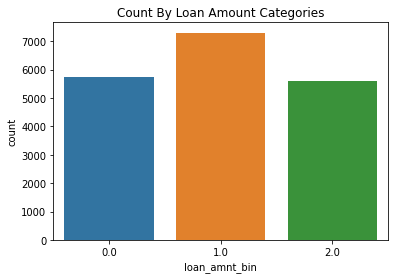

In [59]:
sns.countplot(x="loan_amnt_bin", data=df2_pandas).set(title='Count By Loan Amount Categories')
plt.show()

### Rounded Mean Funded Amount By Loan Amount Bins

In [58]:
#how many loans defaulted for each month (all data is 2015):
df2.groupby('loan_amnt_bin').mean('funded_amnt').na.drop().select("loan_amnt_bin", F.ceil(F.col("avg(funded_amnt)"))).show()

+-------------+----------------------+
|loan_amnt_bin|CEIL(avg(funded_amnt))|
+-------------+----------------------+
|          0.0|                  5857|
|          1.0|                 13752|
|          2.0|                 26118|
+-------------+----------------------+



### Spark SQL

In [51]:
spark.sql("show databases").show()

+------------------+
|      databaseName|
+------------------+
|        big12stats|
|           default|
|          finance2|
|           flights|
|           indexed|
|information_schema|
|          omop_cdm|
|  omop_cdm_parquet|
|   prescribing_dev|
|     prescribing_o|
|     prescribing_p|
|   prescribing_p_e|
|        retaildemo|
|               sys|
|              test|
|       ukcrime_dev|
+------------------+



In [52]:
spark.sql("show tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|             concept|      false|
| default|     concept_synonym|      false|
| default|     device_exposure|      false|
| default|       drug_strength|      false|
| default|   druide_kafka_demo|      false|
| default|flight_not_partit...|      false|
| default|  flight_partitioned|      false|
| default|      lc_predictions|      false|
| default|lc_predictions_la...|      false|
| default|            lc_smote|      false|
| default|   lc_smote_complete|      false|
| default|         lc_smote_k2|      false|
| default|         lc_smote_k3|      false|
| default|         lc_smote_k4|      false|
| default|         lc_smote_k5|      false|
| default|            location|      false|
| default|            metadata|      false|
| default|              myview|      false|
| default|             myview2|      false|
| default|  observation_period| 

#### Saving the Table As Temporary View

In [74]:
## Registering the dataframe as a temporary table:
## Temporary views in Spark SQL are session-scoped and will disappear if the session that creates it terminates. 

df2.createOrReplaceTempView("my_temp_view")

#### Saving the Table Permanently in CDW

In [71]:
## The table will now be a Hive External Table and will show in CDW and Atlas.
## Ranger Policies can now be set on the Table

df2.select(["funded_amnt", "loan_amnt", "installment", "tot_cur_bal"]).write.format('parquet').mode("overwrite").saveAsTable('default.my_hive_table')

Hive Session ID = 613da471-a461-4ffa-9851-73cba1b30a71


In [76]:
spark.stop()